# Toy models of Superposition




In [ ]:
# import packages
from dataclasses import dataclass
from tqdm import trange

import torch
from torch.nn import functional as F

import matplotlib.pyplot as plt
import seaborn as sns


@dataclass
class Config:
    n_features: int 
    n_hidden: int
    batch_size: int

class Model():
    def __init__(self, config, importance=None, nonlinear = False, sparsity=0):
        # store hyperparameters
        self.config = config
        self.importance = importance if importance is not None else torch.ones(config.n_features)
        self.nonlinear = nonlinear
        self.sparsity = sparsity
        # initialise weights and biases
        self.weights = torch.randn(size=(config.n_features, config.n_hidden), requires_grad=True) 
        self.bias = torch.zeros((1,config.n_features), requires_grad=True)
        self.parameters = [self.bias, self.weights]

    def forward(self, x):
        x = x @ self.weights
        x = x @ torch.transpose(self.weights, 0, 1) + self.bias
        x = F.relu(x) if self.nonlinear else x
        return x
    
    def generate_batch(self):
        batch = torch.rand((self.config.batch_size, self.config.n_features))
        mask = torch.rand(batch.shape) < self.sparsity
        batch[mask] = 0
        return batch

    def train(self, lr=0.1, n_steps=10**5):
        # we correct lr for the percentage of zero vectors in the batch whose loss is always zero
        learning_rate =  lr / (1 - self.sparsity ** self.config.n_features)

        loss_hist = []
        for i in trange(n_steps):    
            # generate batch
            x = self.generate_batch()

            # forward pass
            y = self.forward(x)
        
            # compute loss, weighted by the importance of the features
            loss = torch.mean((x-y)**2 * self.importance)
        
            # backward pass
            for p in self.parameters:
                p.grad = None
            loss.backward()

            # update
            for p in self.parameters:
                p.data += -learning_rate * p.grad 
                # p.grad.zero()

            if i % 100 == 0:
                loss_hist.append(loss.log10().item())
            
        self.loss_hist = loss_hist


The input features $x_i$ will be set to zero with a probability of $S_i = S$, but otherwise they will be drawn uniformly from $[0, 1]$. This parameter $S$ is the sparsity and determines how 'sparse' the data is.

In [120]:
import matplotlib.cm as cm

def plot_log10loss(model, ax):
    ax.plot(model.loss_hist)
    
def plot_heatmaps(model, ax1, ax2):
    # get weights, biases and round them off
    wwt = model.weights @ torch.transpose(model.weights, 0, 1)
    wwt = wwt.detach().numpy()
    bias = model.bias.detach().numpy().T

    # heatmap for weights
    sns.heatmap(wwt,  cmap='RdBu', vmin=-1, vmax=1, ax=ax1, linewidths=0.2, cbar=False, square=True)
    ax1.set_xticks([])
    ax1.set_yticks([])
    # heatmap for biases
    sns.heatmap(bias,  cmap='RdBu', vmin=-1, vmax=1, ax=ax2, linewidths=0.2, cbar=True, square=True)
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.subplots_adjust(left=0.0, right=2)
    plt.tight_layout()


def create_plots(model):
    fig, ax = plt.subplots(ncols=2, figsize = (6, 3))
    plot_heatmaps(model, ax[0], ax[1])

In [ ]:
# set dimensions and batchsize of model
config = Config(
    n_features = 10,
    n_hidden = 4,
    batch_size = 30,
 )

# pick the parameters for which we want to plot
nonlinear = [False]+[True]*3
sparsity = [0, 0, 0.7, 0.9]

# create multiple models
models = []
for i in range(len(sparsity)):
    models.append(Model(
        config=config,
        importance= 0.7 ** torch.arange(config.n_features),
        nonlinear=nonlinear[i],
        sparsity=sparsity[i],
    ))

# train the models
for model in models:
    model.train(lr=0.3, n_steps=10**5)


100%|██████████| 100000/100000 [00:11<00:00, 8726.82it/s]


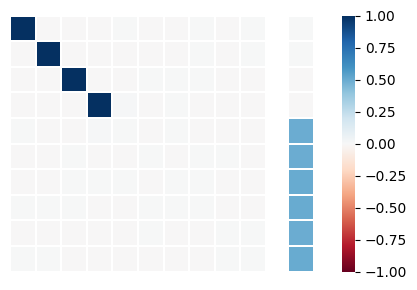

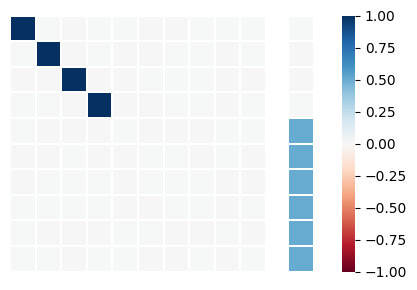

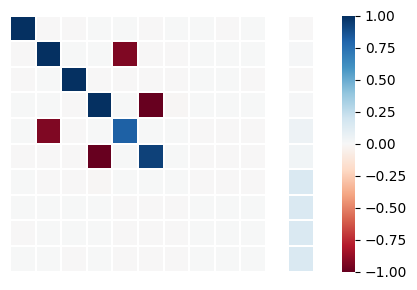

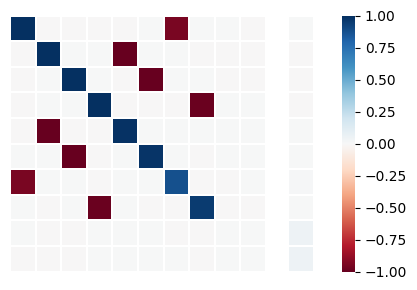

In [ ]:
# display the heatmaps of weights and biases
for model in models:
    create_plots(model)

# ------------- Old text ------------------

In this notebook we recreate some of the results of the 2022 Anthropic paper "Toy models of Superposition". 

One of the interesting properties of neural networks, is that despite the limited number of neurons in their hidden layer, they are often able to recognize and process a wide range of features that severly outnumber the width of the network. The embedding space of tokens for LLM models for example 


sassertions of that paper -- which we recreate here -- is the that neural networks can store many more features in their hiden layers, than the width hidden layers might seem to suggest.


The simple model we study here is an autoencoder that maps a vector $\vec{x} \in \mathbb{R}^n$ into a lower dimensional vector $ \vec{h} \in \mathbb{R}^m$ and then tries to recovers the original vector $\vec{x}$ from it again. We will train the autoencoder to recover this vector as accurately as possible, and inspect which neurons in the $m$-dimensional hidden layer are activated for a given vector. We consider two models: a simple linear model (without any activitation function) and a nonlinear model (with RELU activitation function). We interpret the inout dimension $n$ as the number of features that we want the model to store and assig 

The linear model will essentially be
$$
    x' = W^T W x + b 
$$
and the nonlinear model
$$
    x' = \text{ReLU}(W^T W x + b )
$$
The entroes of the matrix $W$ will be the weights of the model that the model will train to minimize a loss function. This loss function is given by the mean squared error
$$
    L(\vec{x}) = \frac{1}{n} \sum_{i=1}^n I_i (x_i- x'_i)^2,
$$
for a given input vector $\vec{x}$, weighted by the relative `importance' $I_i$. These weights mimic the fact that in most real life ML problems, some features are way more relevant than others, and in this simple toymodel we will always set $I_i = \alpha ^i$ for some $0 < \alpha \leq 1$, such the features are ordered with respect to importance.

This time, we see that the linear model learns to pass the first five features ($x_0, x_1, x_2, x_3$ and $x_4$) along and kills any other input. This makes sense, as the first linear mapping $h = x W$ is a projection and the second transformation $x' = h W^T$ is nothing but an embedding, hence information regarding the distinction between all 20 features must be lost in some way. The model simply acknowledges this therefore only passes the five most important features along as incentivized by the loss function.

### The nonlinear model
The fun starts when we consider the nonlinear model that has a ReLU activiation function at the end. We will see that these models are able to pass along more features than the hidden layers dimension might seem to suggest. An important property of the data that plays a central rol in the enabling this is the notion of sparsity. 

When we talk about data with sparse features, we mean that when we sample a random vector from this sparse data, most features (or components $x_i$) will be zero. In this toymodel, the spasity is modelled by a parameter $S$ which is the probability that a given features is zero. If sparsity $S=0$ than all components $x_i$ of the vector $\vec{x}$ are simply drawn from a uniform distribution $[0, 1]$, but if $S=0.5$ we expect about half of the components to be zero. As $S$ appproaches one the data becomes more sparse and we will see superposition kicking in.

Before we get there, let us run the nonlinear model again, nut with sparsity still set to zero.

Something interesting happened: with sparsity at 0.7 -- meaning that around 70% of the features for a given sample $\vec{x}$ are set to zero -- the model manages to learn more than five features! How does it embed these extra features $x_j$ into the hidden layer? By placing each of them antipodal to some other feature $x_i$, which we can see from the off-diagonal entries in the middle diagram where $W_i W_j = W_jW_i= -1$.

Why does the model compress two features into one dimensions? Let $y$ be such a dimension, then we can see that $y = x_i - x_j$. When only one of these two components is nonzero, we find that for $x_i, x_j \in [0, 1]$ we get 
$$
    y = x_i \qquad \text{and thus} \qquad  \text{ReLU}(y) = x_i \qquad \text{if} \qquad x_j=0
$$
$$
    y = -x_j \qquad \text{and thus} \qquad  \text{ReLU}(-y) = x_j \qquad \text{if} \qquad x_i=0
$$

Of course, this logic no longer works if both features are present in a given sample, but because we set sparsity to 0.7, the odds of sampling a vector with both features $x_i$ and $x_j$ nonzero is $(1-S)^2 = 9 \%$. Hence, the model learns that it's statistically advantagous to create an antipodal pair, despite the fact that in 9% of the samples interference will lead to $\text{ReLU}(y) = 0$ thereby preventing us from recovering both vectors. As we increase sparsity, the risk of interference decreases and the model will learn to create more antipodal pairs to maximize the number of features it can pass along.


At sparsity of 90% we observe even more antipodal pairs. Here, the odds of interference are 1% and hence the model is encouraged to create more antipodal pairs, as the odds of co-occurence is so small. In this case, the number of features that pass through the model is doubled, from four to eight. But if we increase the sparsity even more, can the model find a way to include even the final two (least important) features?


The answer is yes; when we increase the sparsity even more, the model includes all features. It does so  by constructing more complicated superpositions 